# Docling VLM Test
* docling v2.25.0 release introduces VLM pipeline
    * https://github.com/DS4SD/docling/releases/tag/v2.25.0
* example: [[link]](https://github.com/DS4SD/docling/blob/37dd8c1cc7fc05095fe889eec78300647c946a42/docs/examples/minimal_vlm_pipeline.py#L10)
* models:
    * granite-3.1 [[hf link]](https://huggingface.co/ibm-granite/granite-vision-3.1-2b-preview): only supports MD
    * smoldocling [[hf link]](https://huggingface.co/ds4sd/SmolDocling-256M-preview): supports DOCTAGS format (custom docling format)

## VlmPipeline
* https://github.com/DS4SD/docling/blob/37dd8c1cc7fc05095fe889eec78300647c946a42/docling/pipeline/vlm_pipeline.py#L47


## VlmPipelineOptions
* https://github.com/DS4SD/docling/blob/37dd8c1cc7fc05095fe889eec78300647c946a42/docling/datamodel/pipeline_options.py#L334

```
# v2.29
class VlmPipelineOptions(PaginatedPipelineOptions):
    generate_page_images: bool = True
    force_backend_text: bool = (
        False  # (To be used with vlms, or other generative models)
    )
    # If True, text from backend will be used instead of generated text
    vlm_options: Union[InlineVlmOptions, ApiVlmOptions] = (
        smoldocling_vlm_conversion_options
    )
```

## VlmOptions
* uses response_format `DOCTAGS`

```
class HuggingFaceVlmOptions(BaseVlmOptions):
    kind: Literal["hf_model_options"] = "hf_model_options"

    repo_id: str
    load_in_8bit: bool = True
    llm_int8_threshold: float = 6.0
    quantized: bool = False

    response_format: ResponseFormat

    @property
    def repo_cache_folder(self) -> str:
        return self.repo_id.replace("/", "--")


smoldocling_vlm_conversion_options = HuggingFaceVlmOptions(
    repo_id="ds4sd/SmolDocling-256M-preview",
    prompt="Convert this page to docling.",
    response_format=ResponseFormat.DOCTAGS,
)

granite_vision_vlm_conversion_options = HuggingFaceVlmOptions(
    repo_id="ibm-granite/granite-vision-3.1-2b-preview",
    # prompt="OCR the full page to markdown.",
    prompt="OCR this image.",
    response_format=ResponseFormat.MARKDOWN,
)

```

doctags example:
* html like format (similar to qwen2-vl html)
```
<document>
<subtitle-level-1><location><page_1><loc_18><loc_85><loc_83><loc_89></location>DocLayNet: A Large Human-Annotated Dataset for Document-Layout Analysis</subtitle-level-1>
<paragraph><location><page_1><loc_15><loc_77><loc_32><loc_83></location>Birgit Pfitzmann IBM Research Rueschlikon, Switzerland bpf@zurich.ibm.com</paragraph>...
```

In [20]:
import os

from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import (
    AcceleratorDevice,
    VlmPipelineOptions,
    # HuggingFaceVlmOptions, # removed after 2.25
    ResponseFormat
)
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.pipeline.vlm_pipeline import VlmPipeline
from docling.datamodel.pipeline_options_vlm_model import (
    ApiVlmOptions,
    InferenceFramework,
    InlineVlmOptions,
    ResponseFormat,
    TransformersModelType
)

from config import settings

os.environ["DOCLING_ARTIFACTS_PATH"] = str(os.path.join(settings.docling_model_weight_dir, "artifacts"))

In [21]:
sources = [
    # "tests/data/2305.03393v1-pg9-img.png",
    "tests/data/1706.03762v7_pg1_3.pdf",
]

## Use experimental VlmPipeline
pipeline_options = VlmPipelineOptions()
# If force_backend_text = True, text from backend will be used instead of generated text
pipeline_options.force_backend_text = False
pipeline_options.generate_picture_images = True

pipeline_options.accelerator_options.device = AcceleratorDevice.MPS


# pipeline_options.artifacts_path=os.path.join(settings.docling_model_weight_dir, "docling-models/model_artifacts")
# pipeline_options.artifacts_path=settings.docling_model_weight_dir

# Grantie-3.1
# model_dir = os.path.join(
#     settings.docling_model_weight_dir, "model/granite-vision-3.1-2b-preview"
# )
# vlm_conversion_options = HuggingFaceVlmOptions(
#     repo_id = "granite-vision-3.1-2b-preview",
#     # repo_id=model_dir,
#     prompt="OCR the full page to markdown.",
#     # prompt="OCR this image.",
#     response_format=ResponseFormat.MARKDOWN,
#     # response_format=ResponseFormat.DOCTAGS,
#     load_in_8bit=False,
#     quantized=False
# )

# smoldocling-preview
vlm_conversion_options = InlineVlmOptions(
    repo_id = "ds4sd/SmolDocling-256M-preview",
    inference_framework=InferenceFramework.TRANSFORMERS,
    supported_devices=[AcceleratorDevice.MPS],
    transformers_model_type=TransformersModelType.AUTOMODEL_VISION2SEQ,
    prompt="Convert this page to docling.",
    response_format=ResponseFormat.DOCTAGS,
    load_in_8bit=False,
    quantized=False
)

## Pick a VLM model. We choose SmolDocling-256M by default
pipeline_options.vlm_options = vlm_conversion_options

In [22]:
converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_cls=VlmPipeline,
            pipeline_options=pipeline_options,
        ),
        InputFormat.IMAGE: PdfFormatOption(
            pipeline_cls=VlmPipeline,
            pipeline_options=pipeline_options,
        ),
    }
)

In [23]:
# source = "../samples/1706.03762v7_p3.png"
source = "../samples/2305.03393v1-pg9-img.png" # used in docling example
source = "../samples/1706.03762v7_pg1_3.pdf" # 3 pages of attention is all you need

res = converter.convert(source)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/miniconda3/envs/psiking/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/miniconda3/envs/psiking/lib/python3.10/site-packages/transformers/pytorch_utils.py:338: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_eleme

In [ ]:
print(len(res.pages))
for page in res.pages:
    print("")
    print("Predicted page in DOCTAGS:")
    print(page.predictions.vlm_response.text)

3

Predicted page in DOCTAGS:
Assistant: <doctag><page_header><loc_14><loc_136><loc_30><loc_351>arXiv:1706.03672v2 [cs.CL] 2 Aug 2023</page_header>
<section_header_level_1><loc_174><loc_95><loc_326><loc_105>Attention Is All You Need</section_header_level_1>
<text><loc_95><loc_47><loc_399><loc_71>Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.</text>
<section_header_level_1><loc_174><loc_95><loc_326><loc_105>Attention Is All You Need</section_header_level_1>
<text><loc_95><loc_110><loc_412><loc_116>________________________________________________________________________________________</text>
<text><loc_95><loc_148><loc_174><loc_169>Ashish Vaswani* Google Brain avaswani@google.com</text>
<text><loc_200><loc_148><loc_242><loc_169>Noam Shazeer* Google Brain noam@google.com</text>
<text><loc_256><loc_148><loc_324><loc_169>Niki Parmar* Google Research nikip@google.co

In [24]:
print(res.document.export_to_markdown())

## Attention Is All You Need

Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.

## Attention Is All You Need

\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_

Ashish Vaswani* Google Brain avaswani@google.com

Noam Shazeer* Google Brain noam@google.com

Niki Parmar* Google Research nikip@google.com

Jakob Uszkoreit* Google Research usz@google.com

Lion Jones* Google Research llion@google.com

Aidan N. Gomez*† University of Toronto aidan@cs.toronto.edu

Łukasz Kaiser* Google Brain lukaszkaiser@google.com

Illia Polosukhin* † lillia.polosukhin@gmail.com

## Abstract

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models als

DoclingDocument(schema_name='DoclingDocument', version='1.5.0', name='Document', origin=None, furniture=GroupItem(self_ref='#/furniture', parent=None, children=[], content_layer=<ContentLayer.FURNITURE: 'furniture'>, name='_root_', label=<GroupLabel.UNSPECIFIED: 'unspecified'>), body=GroupItem(self_ref='#/body', parent=None, children=[RefItem(cref='#/texts/0'), RefItem(cref='#/texts/1'), RefItem(cref='#/texts/2'), RefItem(cref='#/texts/3'), RefItem(cref='#/texts/4'), RefItem(cref='#/texts/5'), RefItem(cref='#/texts/6'), RefItem(cref='#/texts/7'), RefItem(cref='#/texts/8'), RefItem(cref='#/texts/9'), RefItem(cref='#/texts/10'), RefItem(cref='#/texts/11'), RefItem(cref='#/texts/12'), RefItem(cref='#/texts/13'), RefItem(cref='#/texts/14'), RefItem(cref='#/texts/15'), RefItem(cref='#/texts/16'), RefItem(cref='#/texts/17'), RefItem(cref='#/texts/18'), RefItem(cref='#/texts/19'), RefItem(cref='#/texts/20'), RefItem(cref='#/texts/21'), RefItem(cref='#/texts/22'), RefItem(cref='#/texts/23'), R
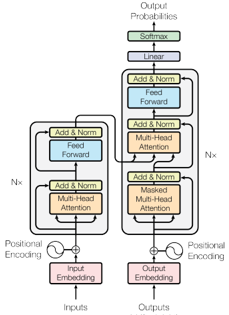
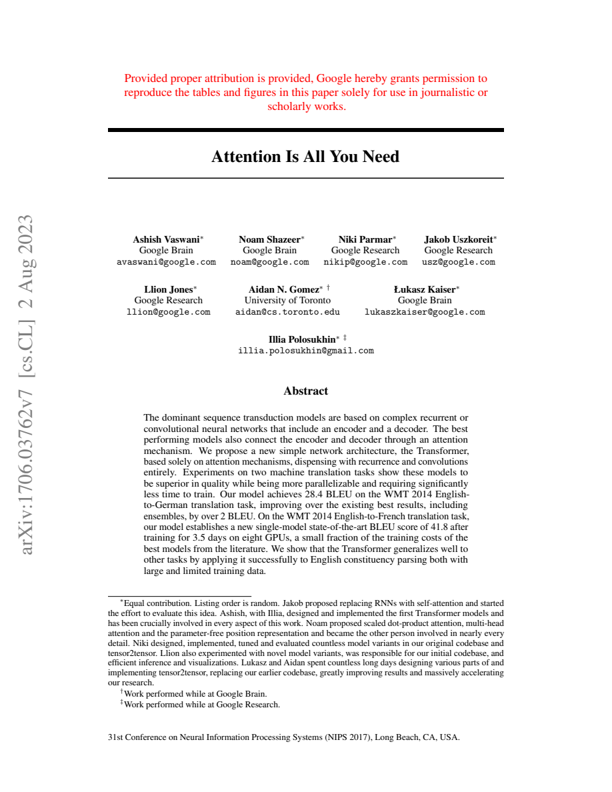
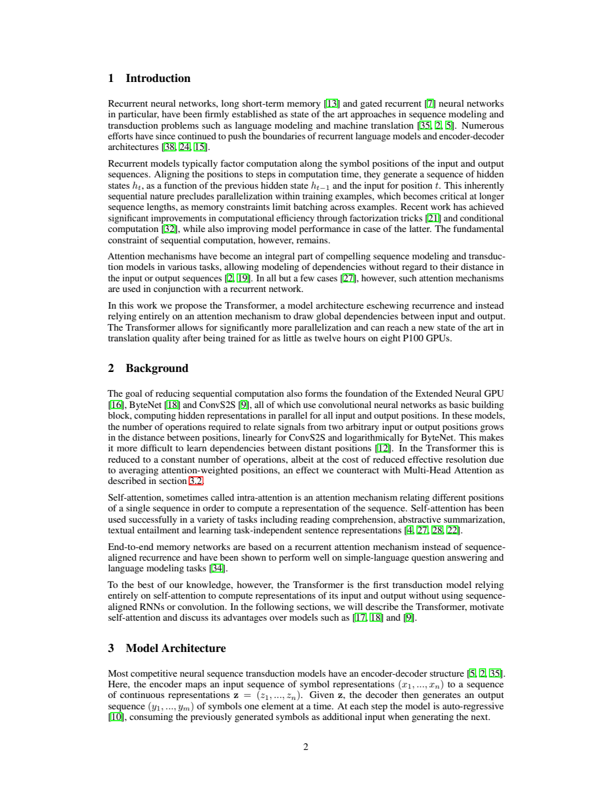
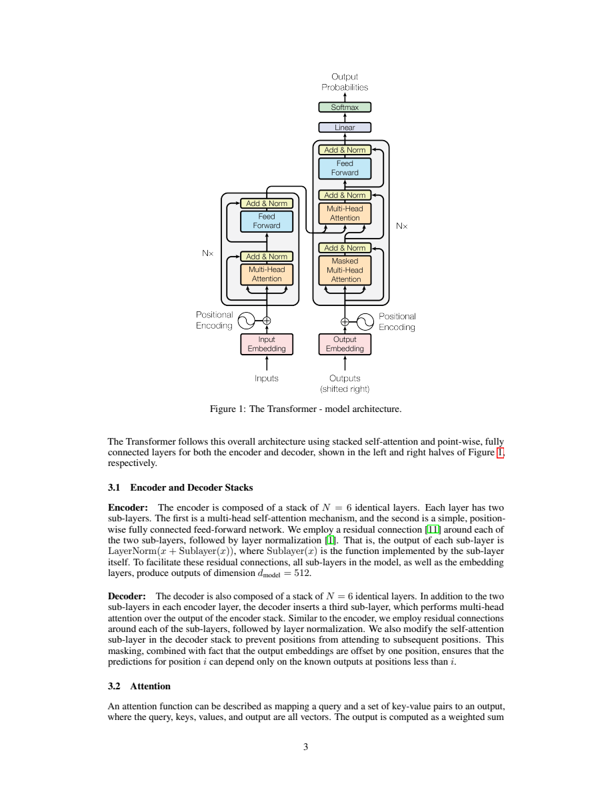

In [25]:
res.document

In [26]:
for item in res.document.body.children:
    print(item)
    # print(type(item))
    
# item = res.document.pictures[0]

cref='#/texts/0'
cref='#/texts/1'
cref='#/texts/2'
cref='#/texts/3'
cref='#/texts/4'
cref='#/texts/5'
cref='#/texts/6'
cref='#/texts/7'
cref='#/texts/8'
cref='#/texts/9'
cref='#/texts/10'
cref='#/texts/11'
cref='#/texts/12'
cref='#/texts/13'
cref='#/texts/14'
cref='#/texts/15'
cref='#/texts/16'
cref='#/texts/17'
cref='#/texts/18'
cref='#/texts/19'
cref='#/texts/20'
cref='#/texts/21'
cref='#/texts/22'
cref='#/texts/23'
cref='#/texts/24'
cref='#/texts/25'
cref='#/texts/26'
cref='#/texts/27'
cref='#/texts/28'
cref='#/texts/29'
cref='#/texts/30'
cref='#/texts/31'
cref='#/texts/32'
cref='#/pictures/0'
cref='#/texts/33'
cref='#/texts/34'
cref='#/texts/35'
cref='#/texts/36'
cref='#/texts/37'
cref='#/texts/38'
cref='#/texts/39'


In [ ]:
# image = item.get_image(res.document)
# print(image)

In [27]:
from pathlib import Path
from docling_core.types.doc import DocItemLabel, ImageRefMode
from docling_core.types.doc.document import DEFAULT_EXPORT_LABELS

res.document.save_as_html(
    filename=Path("./pdf_3_docling_vlm_test_result.html"),
    image_mode=ImageRefMode.REFERENCED,
    labels=[*DEFAULT_EXPORT_LABELS, DocItemLabel.FOOTNOTE],
)

In [28]:
DEFAULT_EXPORT_LABELS

{<DocItemLabel.CHECKBOX_SELECTED: 'checkbox_selected'>,
 <DocItemLabel.CHECKBOX_UNSELECTED: 'checkbox_unselected'>,
 <DocItemLabel.CODE: 'code'>,
 <DocItemLabel.DOCUMENT_INDEX: 'document_index'>,
 <DocItemLabel.FORMULA: 'formula'>,
 <DocItemLabel.KEY_VALUE_REGION: 'key_value_region'>,
 <DocItemLabel.LIST_ITEM: 'list_item'>,
 <DocItemLabel.PAGE_FOOTER: 'page_footer'>,
 <DocItemLabel.PAGE_HEADER: 'page_header'>,
 <DocItemLabel.PARAGRAPH: 'paragraph'>,
 <DocItemLabel.PICTURE: 'picture'>,
 <DocItemLabel.REFERENCE: 'reference'>,
 <DocItemLabel.SECTION_HEADER: 'section_header'>,
 <DocItemLabel.TABLE: 'table'>,
 <DocItemLabel.TEXT: 'text'>,
 <DocItemLabel.TITLE: 'title'>}

In [33]:
from IPython.core.display import display, HTML
html = res.document.export_to_html()[:1000]
# display(HTML(html))

/var/folders/wj/0c7skj2154q4844jqxlw3yxr0000gn/T/ipykernel_84732/219986518.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
